In this section we will provide the results from four modeling approaches.  Three of these 
modeling approaches are defined for you, and you get to choose the fourth approach from the 
list of choices.   
    - For each model provide any relevant or useful model output and a table of the model
    performance in-sample (i.e. on the training data set) and out-of-sample (i.e. on the test data set).   
    - The metrics to be measured are:   
        (1) true positive rate or sensitivity  
        (2) false positive rate  
        (3) the accuracy.  
 
5.a Random Forest  
    - Include the variable importance plot.  
 
5.b Gradient Boosting  
    - Use GBM or XGBoost packages.  Include the variable importance plot.  

5.c Logistic Regression with Variable Selection   
    - Random Forest and Gradient Boosting will identify a pool of interesting predictor 
    variables.  Use that information to help you choose an initial pool of predictor variables.   
    List your initial pool of predictor variables in a table.   
    - Choose a variable selection algorithm.  Use that variable selection algorithm to arrive at 
    an ‘optimal’ logistic regression model.  
    - Since this is a linear model, you should provide a table of the model coefficients and 
    their p-values.  
 
5.d Your Choice – CHAID, Neural Network, SVM, or some other method appropriate for 
binary classification.   
    - Provide the relevant output for the model of choice.  For example SVM has margin 
    plots that are useful, and a neural network allows you to plot out the network topology.  If 
    your chosen method has a ‘standard’ plot that is typically shown with it, then we all 
    expect to see that plot, and you should be providing that plot with the model.

In [48]:
### ref https://blog.jovian.ai/machine-learning-with-python-implementing-xgboost-and-random-forest-fd51fa4f9f4c#b9a9
# !pip install numpy pandas matplotlib seaborn --quiet
# !pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet
# !pip install pyreadr

#importing dataset
import os
# import opendatasets as od
import pandas as pd
import numpy as np
import pyreadr

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import time

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)


In [49]:
credit_card_default_raw = pd.read_csv('./Data/credit_card_default.csv')
# credit_card_default_eng = pd.read_csv('./Data/credit_card_default_eng.csv')
result = pyreadr.read_r('./Data/credit_card_default_eng_features.RData') 
credit_card_default_eng = result[None]

credit_card_default = credit_card_default_eng.copy()
df_flags = credit_card_default_raw[['data.group', 'DEFAULT']]
df_other_features = credit_card_default_raw[['SEX','EDUCATION','MARRIAGE','AGE']]
credit_card_default = credit_card_default.join(df_flags)
credit_card_default = credit_card_default.join(df_other_features)



In [50]:

display(credit_card_default.describe())
display(credit_card_default.head())

,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max,data.group,DEFAULT,SEX,EDUCATION,MARRIAGE,AGE
count,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,3.99390,44976.945200,5275.232094,0.576423,0.375468,-0.090664,6.057244e+04,1.584823e+04,0.682200,1.743900,0.221200,1.603733,1.853133,1.551867,35.485500
std,0.95845,63260.721860,10137.946323,16.499616,0.355618,0.279674,7.840481e+04,3.793356e+04,1.073518,0.830864,0.415062,0.489129,0.790349,0.521970,9.217904
min,3.00000,-56043.166667,0.000000,0.000000,-0.232590,-4.700400,-6.029000e+03,0.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,21.000000
25%,3.00000,4781.333333,1113.291667,0.047855,0.028925,-0.146863,1.006000e+04,2.198000e+03,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,28.000000
50%,4.00000,21051.833333,2397.166667,0.197668,0.286554,-0.004382,3.120850e+04,5.000000e+03,0.000000,1.000000,0.000000,2.000000,2.000000,2.000000,34.000000
75%,5.00000,57104.416667,5583.916667,0.903817,0.692718,0.028105,7.959900e+04,1.210000e+04,2.000000,2.000000,0.000000,2.000000,2.000000,2.000000,41.000000
max,8.00000,877313.833333,627344.333333,2667.199955,5.537758,1.791100,1.664089e+06,1.684259e+06,8.000000,3.000000,1.000000,2.000000,6.000000,3.000000,79.000000


,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max,data.group,DEFAULT,SEX,EDUCATION,MARRIAGE,AGE
0,3.0,1284.000000,114.833333,0.800000,0.064200,-0.195650,3913.0,689.0,2.0,1,1,2,2,1,24
1,3.0,2846.166667,833.333333,0.193583,0.023987,0.006442,3455.0,2000.0,2.0,3,1,2,2,2,26
2,4.0,16942.166667,1836.333333,0.083968,0.187133,-0.158789,29239.0,5000.0,0.0,1,0,2,2,2,34
3,4.0,38555.666667,1398.000000,0.039794,0.769153,-0.360620,49291.0,2019.0,0.0,3,0,2,2,1,37
4,6.0,18223.166667,9841.500000,0.471997,0.364513,0.210580,35835.0,36681.0,0.0,3,0,1,2,1,57


In [51]:
credit_card_default.dtypes

age_bins              float64
bill_avg              float64
payment_avg           float64
ratio_avg             float64
util_avg              float64
balance_growth_6mo    float64
bill_max              float64
payment_max           float64
pay_max               float64
data.group              int64
DEFAULT                 int64
SEX                     int64
EDUCATION               int64
MARRIAGE                int64
AGE                     int64
dtype: object

In [52]:
ccd_train = credit_card_default[credit_card_default['data.group']==1].drop(columns='data.group')
ccd_test = credit_card_default[credit_card_default['data.group']==2].drop(columns='data.group')
ccd_validate = credit_card_default[credit_card_default['data.group']==3].drop(columns='data.group')

print('train data size:', ccd_train.shape)
print('test data size:', ccd_test.shape)
print('validate data size:', ccd_validate.shape)

train data size: (15180, 14)
test data size: (7323, 14)
validate data size: (7497, 14)


In [53]:
X_train = ccd_train.drop(columns='DEFAULT')
X_test = ccd_test.drop(columns='DEFAULT')

y_train = ccd_train['DEFAULT']
y_test = ccd_test['DEFAULT']

Prep for modeling

In [54]:
all_features = credit_card_default_eng.columns
all_features = all_features.tolist()

In [55]:
numerical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind in ['i','f']]
display(numerical_features)
categorical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind not in ['i','f']]
display(categorical_features)

['age_bins',
 'bill_avg',
 'payment_avg',
 'ratio_avg',
 'util_avg',
 'balance_growth_6mo',
 'bill_max',
 'payment_max',
 'pay_max',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE']

[]

In [56]:
### we've done our own splitting

# #import train_test_split library
# from sklearn.model_selection import train_test_split

# # create train test split
# y_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42) 

In [57]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    SimpleImputer(strategy = 'median'),
    # KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'missing'),  # ValueError: 'fill_value'=missing is invalid. Expected a numerical value when imputing numerical data
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),
    
)

In [58]:
preprocessor_best = make_pipeline(preprocessor, 
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 'all')
                                 )

5.a Random Forest

In [59]:

RF_Model = make_pipeline(preprocessor_best, RandomForestClassifier(n_estimators = 100))
RF_Model.fit(X_train, y_train)
RF_Model.score(X_train, y_train)

0.9964426877470356

In [60]:
RF_Model.score(X_test, y_test)

0.7886112249078246

,precision,recall,f1-score,support
0,0.83,0.92,0.87,5766.00
1,0.50,0.29,0.37,1557.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.67,0.61,0.62,7323.00
weighted avg,0.76,0.79,0.77,7323.00


[[5317  449]
 [1099  458]]


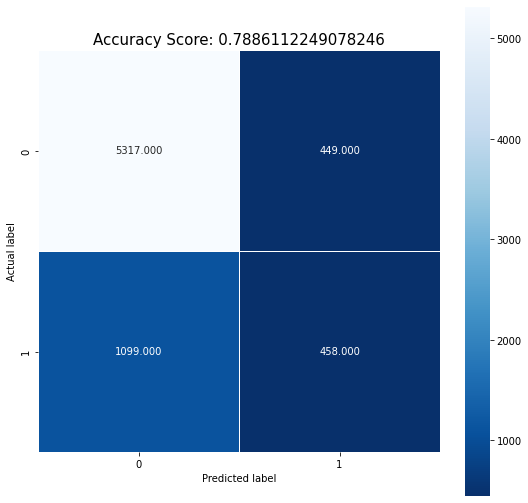

In [61]:
# Ref: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = RF_Model.predict(X_test)
score = RF_Model.score(X_test, y_test)
# print(classification_report(y_test, predictions))
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.round(2))

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


Hyperparameter Tuning

In [62]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 19)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
#Maximum number of levels in tree
max_depth = [2,4,6,8]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [63]:
# Create the param grid
param_grid = {'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_features': max_features,
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': min_samples_split,
               'randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'randomforestclassifier__bootstrap': bootstrap
             }
print(param_grid)

{'randomforestclassifier__n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000], 'randomforestclassifier__max_features': ['auto', 'sqrt'], 'randomforestclassifier__max_depth': [2, 4, 6, 8], 'randomforestclassifier__min_samples_split': [2, 5], 'randomforestclassifier__min_samples_leaf': [1, 2], 'randomforestclassifier__bootstrap': [True, False]}


In [64]:
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = RF_Model, param_distributions = param_grid, cv = None, verbose=1, n_jobs = -1, n_iter = 50, scoring = 'f1')

In [65]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [ ]:
rf_RandomGrid.score(X_train, y_train)

0.4466181061394381

In [ ]:
rf_RandomGrid.score(X_test, y_test)

0.32225300092336107

In [ ]:
rf_RandomGrid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age_bins',
                                                                    'bill_avg',
                                                                    'payment_avg',
                                                                    'ratio_avg',
                                                                    'util_avg',
                                                                    'balance_growth_6mo',
                                                                    'bill_max',
                                                                    'payment_max',
                                                                    'pay_max',
                                                                    'SEX',
                                                                    'EDUCATION',
                                                                    'MAR...
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   [])])),
                                 ('variancethreshold', VarianceThreshold()),
                                 ('selectkbest', SelectKBest(k='all'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        min_samples_leaf=2,
                                        n_estimators=900))])

In [ ]:
print(f'Train : {rf_RandomGrid.score(X_train, y_train):.3f}')
print(f'Test : {rf_RandomGrid.score(X_test, y_test):.3f}')

Train : 0.447
Test : 0.322


In [66]:
preds = rf_RandomGrid.predict(test.iloc[:, 1:31])
output = pd.DataFrame({'Refid': test.RefId, 'IsBadBuy': preds})
output.to_csv('my_submission_rf_model_hyperparameterized.csv', index=False)
print("Your submission was successfully saved!")

NameError: name 'test' is not defined

Try adjusting for imbalanced target

0    23364
1    23364
Name: DEFAULT, dtype: int64


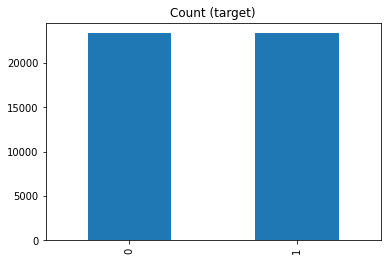

In [67]:
# Fix imbalance
count_class_0, count_class_1 = credit_card_default.DEFAULT.value_counts()

df_class_0 = credit_card_default[credit_card_default.DEFAULT == 0]
df_class_1 = credit_card_default[credit_card_default.DEFAULT == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print(df_test_over.DEFAULT.value_counts())

df_test_over.DEFAULT.value_counts().plot(kind='bar', title='Count (target)');


In [68]:
ccd_train = df_test_over[df_test_over['data.group']==1].drop(columns='data.group')
ccd_test = df_test_over[df_test_over['data.group']==2].drop(columns='data.group')
ccd_validate = df_test_over[df_test_over['data.group']==3].drop(columns='data.group')

print('train data size:', ccd_train.shape)
print('test data size:', ccd_test.shape)
print('validate data size:', ccd_validate.shape)

train data size: (23878, 14)
test data size: (11260, 14)
validate data size: (11590, 14)


In [69]:
X_train = ccd_train.drop(columns='DEFAULT')
X_test = ccd_test.drop(columns='DEFAULT')

y_train = ccd_train['DEFAULT']
y_test = ccd_test['DEFAULT']

Prep for modeling

In [70]:
all_features = credit_card_default.columns
all_features = all_features.tolist()

In [71]:
numerical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind in ['i','f']]
display(numerical_features)
categorical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind not in ['i','f']]
display(categorical_features)

['age_bins',
 'bill_avg',
 'payment_avg',
 'ratio_avg',
 'util_avg',
 'balance_growth_6mo',
 'bill_max',
 'payment_max',
 'pay_max',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE']

[]

In [72]:
### we've done our own splitting

# #import train_test_split library
# from sklearn.model_selection import train_test_split

# # create train test split
# y_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42) 

In [73]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    SimpleImputer(strategy = 'median'),
    # KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'missing'),  # ValueError: 'fill_value'=missing is invalid. Expected a numerical value when imputing numerical data
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),
    
)

In [74]:
preprocessor_best = make_pipeline(preprocessor, 
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 'all')
                                 )

5.a Random Forest

In [75]:

RF_Model = make_pipeline(preprocessor_best, RandomForestClassifier(n_estimators = 100))
RF_Model.fit(X_train, y_train)
RF_Model.score(X_train, y_train)

0.9972359494094983

In [76]:
RF_Model.score(X_test, y_test)

0.6455595026642984

Hyperparameter Tuning

In [77]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 19)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
#Maximum number of levels in tree
max_depth = [2,4,6,8]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [78]:
# Create the param grid
param_grid = {'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_features': max_features,
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': min_samples_split,
               'randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'randomforestclassifier__bootstrap': bootstrap
             }
print(param_grid)

{'randomforestclassifier__n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000], 'randomforestclassifier__max_features': ['auto', 'sqrt'], 'randomforestclassifier__max_depth': [2, 4, 6, 8], 'randomforestclassifier__min_samples_split': [2, 5], 'randomforestclassifier__min_samples_leaf': [1, 2], 'randomforestclassifier__bootstrap': [True, False]}


In [79]:
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = RF_Model, param_distributions = param_grid, cv = None, verbose=1, n_jobs = -1, n_iter = 10, scoring = 'f1')

In [80]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 19.1 s
Wall time: 2min 39s


RandomizedSearchCV(estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('minmaxscaler',
                                                                                                                 MinMaxScaler())]),
                                                                                                ['age_bins',
                                                                                                 'bill_avg',
                                                                                                 'payment_avg',
                                                                                                 'ratio_avg',
                                                                                                 'util_avg',
                                                                                                 'balance_growth_6mo',
                                                                                                 'bill_max',
                                                                                                 'payment_max',
                                                                                                 'pa...
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                                        'randomforestclassifier__max_depth': [2,
                                                                              4,
                                                                              6,
                                                                              8],
                                        'randomforestclassifier__max_features': ['auto',
                                                                                 'sqrt'],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5],
                                        'randomforestclassifier__n_estimators': [100,
                                                                                 150,
                                                                                 200,
                                                                                 250,
                                                                                 300,
                                                                                 350,
                                                                                 400,
                                                                                 450,
                                                                                 500,
                                                                                 550,
                                                                                 600,
                                                                                 650,
                                                                                 700,
                                                                    

In [81]:
rf_RandomGrid.score(X_train, y_train)

0.7644882860665845

In [82]:
rf_RandomGrid.score(X_test, y_test)

0.6820552443500096

In [83]:
rf_RandomGrid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age_bins',
                                                                    'bill_avg',
                                                                    'payment_avg',
                                                                    'ratio_avg',
                                                                    'util_avg',
                                                                    'balance_growth_6mo',
                                                                    'bill_max',
                                                                    'payment_max',
                                                                    'pay_max',
                                                                    'SEX',
                                                                    'EDUCATION',
                                                                    'MAR...
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   [])])),
                                 ('variancethreshold', VarianceThreshold()),
                                 ('selectkbest', SelectKBest(k='all'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        min_samples_leaf=2,
                                        n_estimators=650))])

In [84]:
print(f'Train : {rf_RandomGrid.score(X_train, y_train):.3f}')
print(f'Test : {rf_RandomGrid.score(X_test, y_test):.3f}')

Train : 0.764
Test : 0.682


,precision,recall,f1-score,support
0,0.69,0.77,0.73,5766.00
1,0.73,0.64,0.68,5494.00
accuracy,0.71,0.71,0.71,0.71
macro avg,0.71,0.71,0.71,11260.00
weighted avg,0.71,0.71,0.71,11260.00


[[4437 1329]
 [1963 3531]]


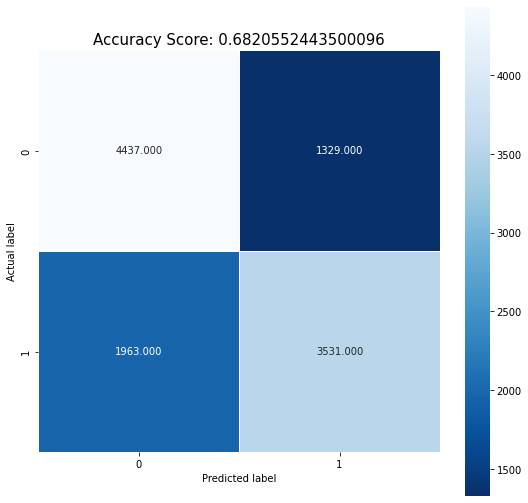

In [85]:
# Ref: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = rf_RandomGrid.predict(X_test)
score = rf_RandomGrid.score(X_test, y_test)
# print(classification_report(y_test, predictions))
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.round(2))

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


Variable Importance

In [89]:

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf_RandomGrid.best_estimator_, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())


Weight,Feature
0.1720 ± 0.0028,pay_max
0.0383 ± 0.0020,payment_avg
0.0348 ± 0.0016,payment_max
0.0337 ± 0.0010,balance_growth_6mo
0.0314 ± 0.0010,bill_max
0.0257 ± 0.0012,util_avg
0.0234 ± 0.0010,bill_avg
0.0217 ± 0.0015,ratio_avg
0.0130 ± 0.0007,AGE
0.0088 ± 0.0014,EDUCATION


In [1]:
plt.boxplot(results, labels=names, showmeans=True)


NameError: name 'plt' is not defined